---

Name: Divani Rafitya
- [Dataset](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=gc-5-credit-card)
- [Hugging Face](https://huggingface.co/spaces/divanirafitya/Credit_Card_Default)

---

## Business Understanding

Dari Dataset yang diambil dari BigQuery, dataset menunjukkan historical data dari sebuah bank dengan layanan kartu kredit. Sebagai data scientist, kita diminta untuk mengidentifikasi faktor-faktor yang dapat mempengaruhi probabilitas gagal bayar kartu kredit pada bulan berikutnya.

Oleh karena itu, terbentuklah objective untuk dapat memprediksi apakah customer dapat membayar tagihan kartu kredit (No Default) atau gagal bayar (Default) di bulan berikutnya berdasarkan historical data dan limit balancenya untuk mengurangi kerugian bank dengan mengevaluasi kredit terhadap customer untuk menilai kemampuan customer dalam membayar pinjaman kartu kredit di bulan tersebut sebelum memberikan pinjaman.

Berdasarkan penjabaran diatas, SMART Goals yang ingin dicapai adalah:
Membuat model machine learning untuk dapat mengurangi kerugian bank dengan memprediksi apakah customer dapat membayar tagihan kartu kredit pada bulan depan atau tidak. Model machine learning ini akan membandingkan metode/model LogisticRegression, KNeighborsClassifier (KNN), dan Support Vector Machine (SVM) untuk menentukan model apa yang terbaik. 

Dalam hal ini, false positif di definisikan sebagai penolakan transaksi yang sah atau pembekuan kartu secara tidak perlu yang dapat membuat customer kehilangan kepercayaan kepada bank, sedangkan false negatif adalah tidak terdeteksinya transaksi curang yang dilakukan secara tidak sah yang dapat merusak reputasi bank.
Untuk itu, metrics classification akan menggunakan F1 Score dengan pertimbangan False Positive dan False Negative sama pentingnya diminimalisir untuk mengurangi kerugian bank penerbit kartu kedit.

## Query SQL

<!-- connect data from bigquery -->
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

<!-- select project id on Google Cloud Platform -->
project_id = "gc-5-credit-card"
client = bigquery.Client(project=project_id)

<!-- query data -->
```sql
df = client.query('''
SELECT 
  limit_balance,
  CAST(sex AS INT) AS sex, #convert data type to int
  CAST(education_level AS INT) AS education_level, #convert data type to int
  CAST(marital_status AS INT) AS marital_status, #convert data type to int
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  CAST(pay_5 AS FLOAT) AS pay_5, #convert data type to float
  CAST(pay_6 AS FLOAT) AS pay_6, #convert data type to float
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  CAST(default_payment_next_month AS INT) AS default_payment_next_month #convert data type to int
FROM `bigquery-public-data.ml_datasets.credit_card_default`
''').to_dataframe()
```

## Import Libraries

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# import feature engineering
from feature_engine.outliers import Winsorizer
import phik
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# import model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# import hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# import warnings
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
# loading dataset from .csv file to pandas dataframe
df_ori = pd.read_csv('credit_card_default_dataset.csv')
pd.set_option('display.max_columns',None) #display all columns

In [3]:
# duplicate original dataset
df = df_ori.copy()

In [4]:
# show first 10 rows as sample
df.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [5]:
# show last 10 rows as sample
df.tail(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [6]:
# show dataframe summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [7]:
# check missing value in dataset
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

In [8]:
# check for duplications in dataset
df.duplicated().sum()

1

Berdasarkan informasi di atas, insight yang diperoleh adalah sebagai berikut:
- Dataset ini terdiri dari `24 columns` dengan total `2965 data entries`.
- Tipe data untuk setiap column sudah sesuai.
- Tidak terdapat missing value pada dataset.
- Terdapat `1 data duplicate` dalam dataset.

Untuk itu, pada data loading kita drop dulu data duplicate nya agar dapat diolah.

In [9]:
# drop data duplicates
df = df.drop_duplicates()

In [10]:
# check dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   marital_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 non-n

Setelah dilakukan drop duplicates, jumlah data entries menjadi 2964 entries.

## Exploratory Data Analysis

#### Pertama, saya ingin melihat persentase dari 'default_payment_next_month' terlebih dahulu menggunakan pie chart.

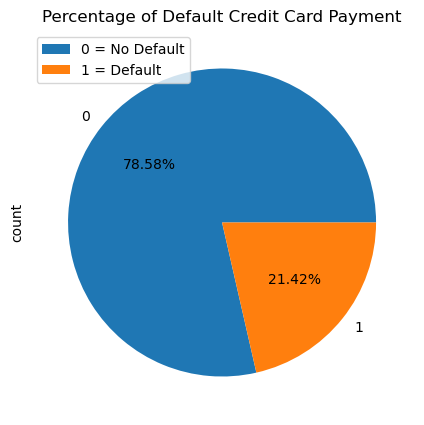

In [11]:
# data visualization
fig,ax1 = plt.subplots(figsize=(5,5))

df['default_payment_next_month'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Percentage of Default Credit Card Payment')
plt.legend(['0 = No Default','1 = Default'])
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah perbedaan jumlah customer yang gagal bayar dan tidak gagal bayar sangat signifikan, dimana hal ini menandakan bahwa diperkirakan 78.58% customer akan berhasil membayar tagihan kartu kredit pada bulan depan dengan persentase No Default lebih besar +21.42%.

#### Kedua, saya ingin melihat jumlah customer berdasarkan statusnya menggunakan pie chart.

Dengan asumsi bahwa data unknown pada 'marital_status' termasuk dalam kategori others, maka saya akan menggabungkannya terlebih dahulu menggunakan replace.

In [12]:
# change unknown to other with replace
df['marital_status'] = df['marital_status'].replace(0,3)

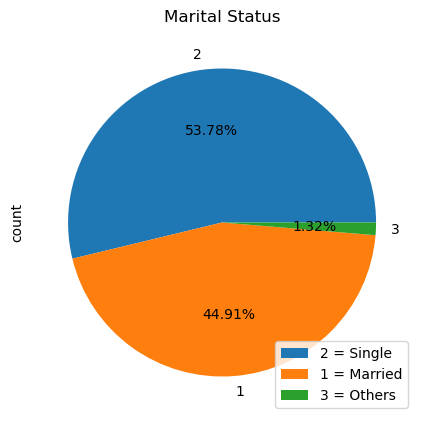

In [13]:
# data visualization
fig,ax1 = plt.subplots(figsize=(5,5))

df['marital_status'].value_counts().plot(kind='pie', autopct='%.2f%%',ax=ax1)
plt.title('Marital Status')
plt.legend(['2 = Single','1 = Married','3 = Others'])
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah perbedaan persentase jumlah status pernikahan customer yang tidak terlalu jauh antara single dan married, dengan persentase perbedaan hanya +8.87%. Sedangkan, terdapat 1.32% customer yang termasuk kedalam kategori others, seperti divorced atau tidak mengisi statusnya.

#### Ketiga, saya ingin melihat jumlah customer berdasarkan level edukasinya menggunakan bar chart.

Dengan asumsi bahwa data unknown pada 'education_level' termasuk dalam kategori others, maka saya akan menggabungkannya terlebih dahulu menggunakan replace.

In [14]:
# change unknown to other with replace
df['education_level'] = df['education_level'].replace([0,5,6],4)

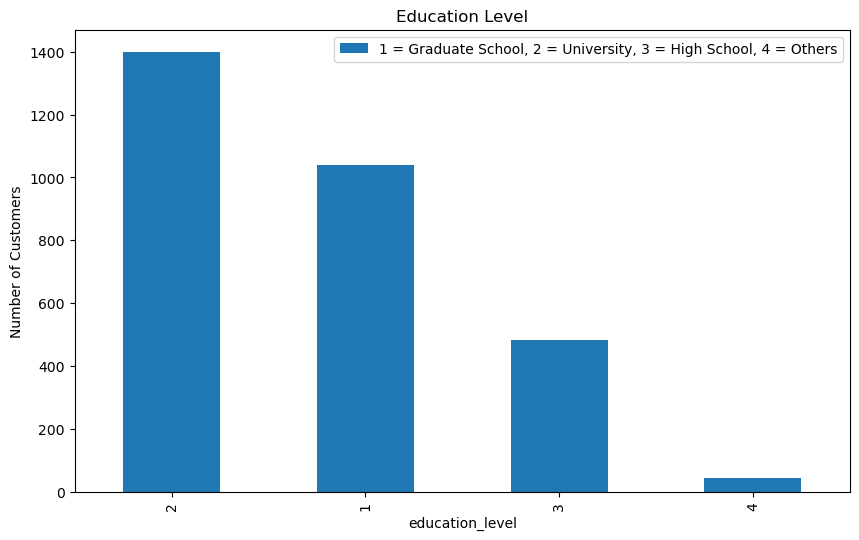

In [15]:
# data visualization
fig,ax1 = plt.subplots(figsize=(10,6))

df['education_level'].value_counts().plot(kind='bar')
plt.title('Education Level')
plt.xlabel('education_level')
plt.ylabel('Number of Customers')
plt.legend(labels=['1 = Graduate School, 2 = University, 3 = High School, 4 = Others'])
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah education level dari customer credit card yang paling banyak berasal dari lulusan university yaitu 1400 customer, dengan perbedaan yang cukup signifikan jika dibandingkan dengan lulusan lainnya.

#### Keempat, saya ingin melihat jumlah customer berdasarkan umurnya menggunakan bar chart.

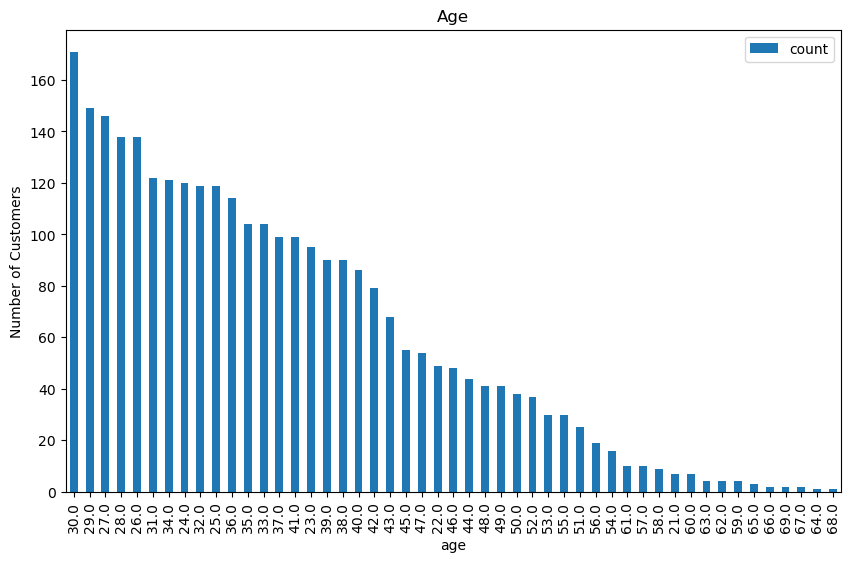

In [16]:
# data visualization
fig,ax1 = plt.subplots(figsize=(10,6))

df['age'].value_counts().plot(kind='bar')
plt.title('Age')
plt.xlabel('age')
plt.ylabel('Number of Customers')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah umur dari customer credit card yang bervariasi, dengan dominasi umur yang paling banyak ada pada range umur 24-36 dimana jumlah customer tiap usia lebih dari 100 orang.

#### Kelima, saya ingin melihat distribusi limit balance menggunakan histogram.

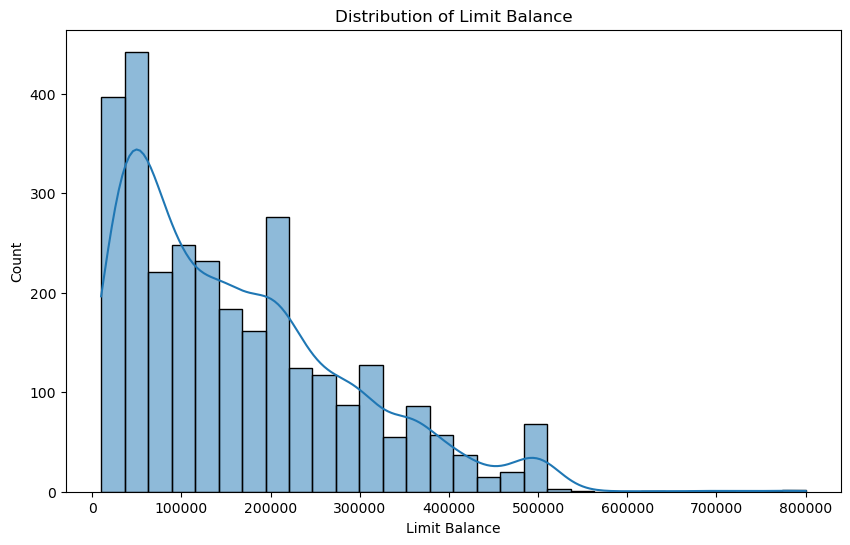

In [17]:
# data visualization
fig,ax1 = plt.subplots(figsize=(10,6))

sns.histplot(df['limit_balance'], bins=30, kde=True)
plt.title('Distribution of Limit Balance')
plt.xlabel('Limit Balance')
plt.ylabel('Count')
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah sebagai berikut:
- Distribusi data pada limit balance condong kearah kiri, dimana nilai skewed ke kiri menandakan bahwa kemungkinan adanya outliers yang berada pada sisi kanan data.
- Jumlah customer yang memiliki jumlah limit kartu kredit yang kecil sangat banyak, dengan dominasi 348 orang memiliki limit balance 50000 dan sekitar 200 orang memiliki limit balance 20000.

#### Keenam, saya ingin melihat distribusi limit balance berdasarkan default payment next month menggunakan bar chart.

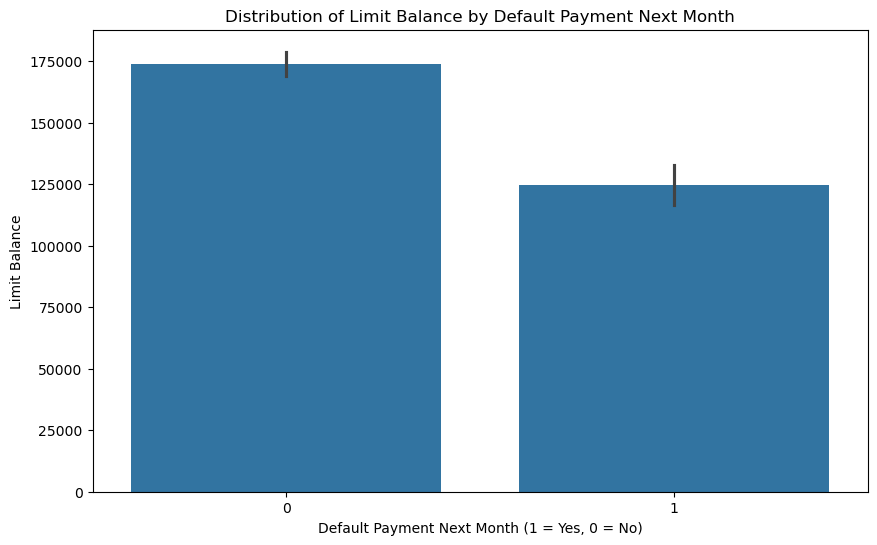

In [18]:
# data visualization
fig,ax1 = plt.subplots(figsize=(10,6))

sns.barplot(data=df,x='default_payment_next_month',y='limit_balance')
plt.title('Distribution of Limit Balance by Default Payment Next Month')
plt.xlabel('Default Payment Next Month (1 = Yes, 0 = No)')
plt.ylabel('Limit Balance')
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah semakin tinggi limit kartu kreditnya maka probabilitas customer untuk membayar tagihannya bulan berikutnya makin besar.

#### Ketujuh, saya ingin melihat distribusi default payment berdasarkan gender/sex menggunakan barplot.

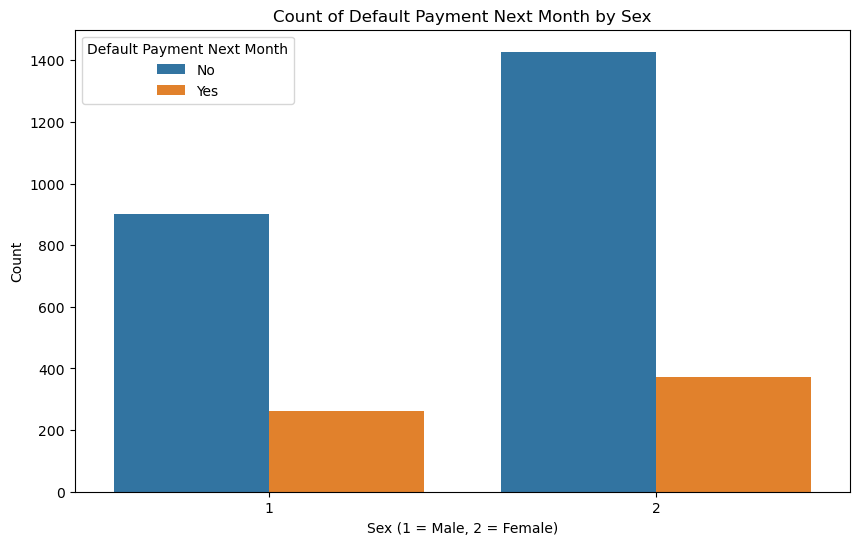

In [19]:
# data visualization
fig,ax1 = plt.subplots(figsize=(10,6))

sns.countplot(data=df,x='sex', hue='default_payment_next_month')
plt.title('Count of Default Payment Next Month by Sex')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Count')
plt.legend(title='Default Payment Next Month', labels=['No', 'Yes'])
plt.show()

Berdasarkan gambar diatas, insight yang diperoleh adalah sebagai berikut:
- Perbedaan jumlah gender Male dan Female sangat signifikan, dimana customer kartu kredit didominasi oleh gender Female.
- Customer Female memiliki kemampuan untuk membayar tagihan kartu kredit untuk bulan depan lebih besar daripada Male.

## Feature Engineering

### Split Feature as `x` and Target as `y`

Pada feature engineering, langkah pertama yang harus dilakukan adalah mendefinisikan feature dan target/labelnya yang ada pada dataset terlebih dahulu. 
- Feature: variable yang digunakan untuk membantu membuat prediksi.
- Target: hasil nilai yang diprediksi oleh machine learning terhadap fiturnya.

Pada kasus ini, `labelnya adalah default_payment_next_month`.

In [20]:
# split feature with target/label
X = df.drop('default_payment_next_month',axis=1) #feature
y = df['default_payment_next_month'] #label

# show first 5 rows from feature dataset
X.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,4,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,4,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0


### Split Train-set and Test-set

Selanjutnya adalah mengelompokkan dua bagian penting pada machine learning, yaitu train-set dan test-set.
- Train-set akan digunakan untuk melatih model machine learning untuk mempelajari pattern/pola pada data yang ada.
- Test-set akan digunakan untuk menguji dan mengevaliasi hasil machine learning dalam melakukan prediksi pada data baru.

In [21]:
# splitting between train-set and test-set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10)

print('X Train size : ', X_train.shape)
print('X Test size : ', X_test.shape)

X Train size :  (2371, 23)
X Test size :  (593, 23)


In [22]:
# check first 5 rows from X_train dataset
X_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
48,310000.0,1,1,2,45.0,0.0,0.0,0.0,0.0,0.0,0.0,313268.0,278821.0,283847.0,290135.0,293350.0,300623.0,10010.0,11500.0,11015.0,11000.0,12000.0,23035.0
2168,140000.0,1,1,2,28.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,3234.0,4324.0,5477.0,4490.0,1500.0,-51183.0,4340.0,5491.0,2013.0,1510.0,18.0,89898.0
1767,140000.0,2,2,1,45.0,0.0,0.0,0.0,2.0,2.0,2.0,55444.0,57549.0,60971.0,61374.0,63243.0,64554.0,3000.0,5000.0,2000.0,3000.0,2500.0,0.0
2382,210000.0,2,2,1,41.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,13340.0,42862.0,9584.0,7978.0,6728.0,6728.0,42000.0,9600.0,7978.0,6728.0,6728.0,6728.0
2563,290000.0,1,1,1,37.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-17.0,3465.0,10069.0,4225.0,-4.0,871.0,3482.0,10194.0,4276.0,0.0,875.0,3852.0


In [23]:
# check first 5 rows from X_test dataset
X_test.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
2423,360000.0,2,2,2,53.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,10733.0,15206.0,15000.0,9744.0,11114.0,8123.0,15206.0,15032.0,9769.0,11114.0,8123.0,8736.0
2555,260000.0,1,1,2,30.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2322.0,1233.0,3302.0,6592.0,5008.0,3386.0,1233.0,3302.0,6592.0,5008.0,3386.0,2547.0
1442,120000.0,1,2,1,30.0,1.0,2.0,2.0,2.0,0.0,0.0,80226.0,81812.0,82922.0,80989.0,82761.0,84766.0,3500.0,3000.0,0.0,3120.0,3500.0,3100.0
1873,140000.0,1,2,2,28.0,2.0,2.0,2.0,2.0,2.0,2.0,12642.0,13740.0,13818.0,13994.0,14222.0,14537.0,1600.0,600.0,700.0,600.0,700.0,600.0
1561,500000.0,1,1,1,47.0,-1.0,2.0,-1.0,0.0,0.0,-1.0,7233.0,2321.0,18261.0,16456.0,11225.0,36770.0,0.0,18261.0,0.0,0.0,40270.0,0.0


### Handling Missing Value

Jika terdapat missing value pada X_train/X_test maka y_train/y_test di drop juga based on index, begitu pula sebaliknya.

In [24]:
# check missing values in train-set
X_train.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [25]:
# check missing values in test-set
X_test.isna().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [26]:
# check missing values in train-set
y_train.isna().sum()

0

In [27]:
# check missing values in test-set
y_test.isna().sum()

0

Dari hasil pengecekan, tidak terdapat missing value pada train-set dan test-set.

### Handling Outliers

Dikarenakan handling outlier hanya dilakukan pada kolom numerik, kita akan memisahkan column numerical terlebih dahulu.

In [28]:
# split numerical and categorical column
numerical = ['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
cat_encoded = ['sex','education_level','marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

print(f'Numerical columns   : {numerical}')
print(f'Categorical columns : {cat_encoded}')

Numerical columns   : ['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
Categorical columns : ['sex', 'education_level', 'marital_status', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


Selanjutnya adalah pengecekan skewness pada masing-masing column numerical sebelum melakukan handling outlier.

In [29]:
# check skewness for numerical columns
skew_result = []
for i in numerical:
    skewness = X_train[i].skew()
    skew_result.append((i, skewness))

for i, skewness in skew_result:
    print(f"Skewness {i}: {skewness}")

Skewness limit_balance: 0.9891516996217267
Skewness age: 0.8077966863968985
Skewness bill_amt_1: 2.395285159586924
Skewness bill_amt_2: 2.392578185503851
Skewness bill_amt_3: 2.6001191565276973
Skewness bill_amt_4: 2.444410370655679
Skewness bill_amt_5: 2.396489377052562
Skewness bill_amt_6: 2.442472850355539
Skewness pay_amt_1: 11.425242447123527
Skewness pay_amt_2: 30.37996961410859
Skewness pay_amt_3: 7.794572800994112
Skewness pay_amt_4: 8.767060468657471
Skewness pay_amt_5: 11.955417259433656
Skewness pay_amt_6: 10.251590745452503


Untuk mempermudah pengerjaan, kita akan mengkategorikan column berdasarkan distribusi datanya menggunakan looping `for in` untuk column numerical.

In [30]:
# create list to contain default value
normal = []
moderate = []
extreme = []

# create looping with for in
for i in numerical:
    skew = X_train[i].skew() #to input i in list
    if -0.5 < skew and skew < 0.5:
        normal.append(i)
    elif -1 <= skew <= -0.5 or 0.5 <= skew <= 1:
        moderate.append(i)
    elif skew < 1 or skew > 1:
        extreme.append(i)

print(f"Normal distribution: {normal}")
print(f"Moderate distribution: {moderate}")
print(f"Extreme distribution: {extreme}")

Normal distribution: []
Moderate distribution: ['limit_balance', 'age']
Extreme distribution: ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


Selanjutnya, handling outlier akan dilakukan dengan metode capping terhadap X_train. Metode capping dipilih karena dirasa cara yang paling efektif untuk handling outlier, dimana `metode capping tidak menghapus/mengurangi data outlier melainkan hanya press datanya saja` dengan mengubah nilai outlier yang dapat mempengaruhi analisis menjadi nilai yang masuk akal.

In [31]:
# capping outliers using winsoriser
winsoriser_moderate = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=1.5, #moderate
                             variables=moderate)

X_train = winsoriser_moderate.fit_transform(X_train)

# capping outliers using winsoriser
winsoriser_extreme = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3, #extreme
                             variables=extreme)

X_train = winsoriser_extreme.fit_transform(X_train)

Dalam hal ini, handling outlier hanya dilakukan terhadap X_train saja karena kita ingin menguji model mission learning berdasarkan data aslinya untuk mencapai hasil train-set dan test-set yang detail dan akurat. Selain itu, hal ini dilakukan untuk membiasakan X_train jika ada data baru yang memiliki distribusi natural outlier. Alasan lainnya tidak menguji X_test adalah karena kita ingin hasil dari X_test apa adanya sehingga tidak dilakukan handling outlier.

In [32]:
# check skewness after capping
skew_result = []
for i in numerical:
    skewness = X_train[i].skew()
    skew_result.append((i, skewness))

for i, skewness in skew_result:
    print(f"Skewness {i}: {skewness}")

Skewness limit_balance: 0.8749666958952749
Skewness age: 0.7388135203957106
Skewness bill_amt_1: 1.7703915578544014
Skewness bill_amt_2: 1.7651129105247598
Skewness bill_amt_3: 1.7570771756008081
Skewness bill_amt_4: 1.7685445482664965
Skewness bill_amt_5: 1.7400016559326887
Skewness bill_amt_6: 1.7545774578111935
Skewness pay_amt_1: 1.6210603433515292
Skewness pay_amt_2: 1.6987571226752372
Skewness pay_amt_3: 1.8111840256801721
Skewness pay_amt_4: 1.8241060380171223
Skewness pay_amt_5: 1.8252021329318662
Skewness pay_amt_6: 1.8501515663745867


Setelah melakukan handling outlier dengan metode capping, berikut adalah hasil pengecekan skewnessnya.

### Correlation for Feature Selection

Langkah pertama untuk melakukan feature selection adalah dengan pengecekan korelasi terlebih dahulu.
Untuk pengecekan korelasi, kita menggunakan library phik karena dapat mengolah data numerical dan categorical sekaligus.

In [33]:
# merge label with feature using pd.concat
combined = pd.concat([X_train,y_train], axis=1)

In [34]:
# calculate correlation matrix with phik
phik_overview = combined.phik_matrix()
phik_overview['default_payment_next_month']

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


limit_balance                 0.212786
sex                           0.037987
education_level               0.125431
marital_status                0.000000
age                           0.044607
pay_0                         0.592601
pay_2                         0.479240
pay_3                         0.335836
pay_4                         0.415545
pay_5                         0.409139
pay_6                         0.368629
bill_amt_1                    0.012262
bill_amt_2                    0.055922
bill_amt_3                    0.026083
bill_amt_4                    0.066895
bill_amt_5                    0.051719
bill_amt_6                    0.040492
pay_amt_1                     0.181529
pay_amt_2                     0.178759
pay_amt_3                     0.141912
pay_amt_4                     0.140383
pay_amt_5                     0.127486
pay_amt_6                     0.148977
default_payment_next_month    1.000000
Name: default_payment_next_month, dtype: float64

Dari hasil correlation matrix diatas, hasil korelasi fitur terhadap label/target memiliki nilai yang berbeda-beda. Dalam hal ini, kita hanya akan mengambil hasil nilai korelasi > 0.2 dikarenakan korelasi feature sangat lemah terhadap label/target jika mengambil korelasi yang terlalu kecil hubungannya.

In [35]:
# choose correlation > 0.2
feature = ['limit_balance','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']

# feature selection from train-set and applied to test-set
X_train_feature = X_train[feature]
X_test_feature = X_test[feature]

Selanjutnya, kita mengelompokkan hasil feature selection tersebut kedalam kategori numerical dan categorical.

In [36]:
# split numerical and categorical column after feature selection
numerical = ['limit_balance']
cat_encoded = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']

print(f'Numerical columns   : {numerical}')
print(f'Categorical columns : {cat_encoded}')

Numerical columns   : ['limit_balance']
Categorical columns : ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


In [37]:
# split to numerical and categorical
X_train_num = X_train[numerical]
X_test_num = X_test[numerical]

X_train_cat = X_train[cat_encoded]
X_test_cat = X_test[cat_encoded]

In [38]:
# check numerical
X_train_num.head()

,limit_balance
48,310000.0
2168,140000.0
1767,140000.0
2382,210000.0
2563,290000.0


In [39]:
# check categorical
X_train_cat.head()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
48,0.0,0.0,0.0,0.0,0.0,0.0
2168,0.0,-1.0,-1.0,0.0,-1.0,-1.0
1767,0.0,0.0,0.0,2.0,2.0,2.0
2382,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
2563,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


Dalam hal ini, feature yang termasuk kedalam kategori numerical hanya 'limit_balance' karena feature 'pay_0','pay_2','pay_3','pay_4','pay_5','pay_6' sudah dalam bentuk encoding sehingga termasuk kedalam kategori categorical. 

### Cardinality

Pada tahap ini, pengecekan cardinality dilakukan dengan melihat value unik pada column categorical. Lalu, akan dilakukan reduce cardinality jika nilai cardinality diatas 12, dimana hal ini bertujuan untuk mendapatkan prediksi yang lebih baik.

In [40]:
# check cardinality on categorical column
X_train_cat.nunique()

pay_0    11
pay_2    10
pay_3     9
pay_4     9
pay_5     8
pay_6     8
dtype: int64

In [41]:
# check cardinality from categorical column
print('Number of categories in the variable pay_0: {}'.format(len(df.pay_0.unique())))
print('Number of categories in the variable pay_2: {}'.format(len(df.pay_2.unique())))
print('Number of categories in the variable pay_3: {}'.format(len(df.pay_3.unique())))
print('Number of categories in the variable pay_4: {}'.format(len(df.pay_4.unique())))
print('Number of categories in the variable pay_5: {}'.format(len(df.pay_5.unique())))
print('Number of categories in the variable pay_6: {}'.format(len(df.pay_6.unique())))

Number of categories in the variable pay_0: 11
Number of categories in the variable pay_2: 10
Number of categories in the variable pay_3: 9
Number of categories in the variable pay_4: 10
Number of categories in the variable pay_5: 9
Number of categories in the variable pay_6: 8


Setelah melakukan pengecekan cardinality, hasil menunjukkan bahwa tidak ada nilai cardinality yang diatas 12, artinya tidak perlu melakukan reduce cardinality pada column categorical.

### Pipeline

Selanjutnya adalah melakukan `pipeline` untuk menggabungkan beberapa langkah preprocessing data.
Karena distribusi data untuk 'limit_balance' adalah moderate skewed distribution, pada kasus ini scaling yang cocok digunakan adalah MinMaxScaler.

Pada tahap preprocessing, tidak dilakukan encoding karena column categorical sudah dalam bentuk encode yang akan di passthrough.

In [42]:
# scaling and encoding using columntransformer
preprocess = ColumnTransformer([
    ('scaler', MinMaxScaler(), numerical),
],remainder='passthrough')

Dalam hal ini, X_train akan diuji dengan model clasification LogisticRegression, KNeighborsClassifier, SVC. Berikut adalah pertimbangan untuk menggunakan model ini pada kasus kartu kredit default:

1. LogisticRegression: dapat mengolah dataset yang relatif besar untuk data linear. Dalam hal ini, logistic regression akan mengklasifikasikan customer berdasarkan Default dan No Default.
2. KNeighborsClassifier (KNN): melakukan perhitungan jarak antar titik data menggunakan K sehingga dapat menangkap pola yang mungkin tidak dapat ditangkap oleh model LogisticRegression yang sifatnya linear, karena KNN bersifat non linear. Dalam hal ini, KNN akan mempertimbangkan pola customer yang memiliki karakteristik yang serupa
3. Support Vector Machine (SVM): memiliki kemampuan untuk menangani data yang kompleks dengan menggunakan kernel untuk pemisahan data dan menggunakan parameter untuk menangani imbalance data, seperti C dan gamma. Dalam hal ini, SVM akan memisahkan customer Default dan No Default.

Dengan menggabungkan ketiga model tersebut, kita dapat melakukan cross-validation untuk memastikan konsistensi dan akurasi dengan cara membagi data menjadi subset yang lebih kecil untuk menghindari overfitting. Tujuan utama dari cross-validation adalah memberikan perkiraan yang lebih akurat tentang bagaimana model akan perform pada data baru.

In [43]:
# define model using pipeline
pipe_log = make_pipeline(preprocess, LogisticRegression())
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocess, SVC())

Selanjutnya akan dilakukan cross-validation dengan membagi data menjadi train-set dan validation-set untuk mengevaluasi kinerja model dan memilih model yang memberikan hasil terbaik berdasarkan metric evaluasi yang dipilih.
Dalam hal ini, metric evaluasi yang dipilih adalah F1 score dengan pertimbangan 2 hal penting. Pertama adalah F1 akan memberikan nilai yang lebih baik dibandingkan precision atau recall karena menggabungkan precision dan recall menjadi satu metric. Kedua, distribusi data pada default_payment_next_month yang tidak seimbang, dimana akan missleading jika menggunakan accuracy.

In [44]:
# cross validation for each model
cv_log = cross_val_score(pipe_log, X_train_feature, y_train, cv=5,scoring='f1',n_jobs=-1) #cv=5 artinya dia fold 5x
cv_knn = cross_val_score(pipe_knn, X_train_feature, y_train, cv=5,scoring='f1',n_jobs=-1)
cv_svc = cross_val_score(pipe_svc, X_train_feature, y_train, cv=5,scoring='f1',n_jobs=-1)

In [45]:
# looping to find each model
models = []
cv_score = 0
for cv,name in zip([cv_log, cv_knn, cv_svc],
                   ['log', 'knn', 'svc']):
  print(name)
  print(f'f1 - Cross Validation - All : {cv}')
  print(f'f1 - Cross Validation - Mean : {cv.mean()}') 
  print(f'f1 - Cross Validation - Std : {cv.std()}')
  print(f'f1 - Cross Validation - Range : {cv.mean()-cv.std()} - {cv.mean()+cv.std()}')
  print('-'*50)

  if cv.mean() > cv_score:
    cv_score = cv.mean()
    best_model = name
  else:
    pass

print(f'Best Model : {best_model}')
print(f'Cross Validation Mean From Best Model : {cv_score}')

log
f1 - Cross Validation - All : [0.35658915 0.34108527 0.45070423 0.41666667 0.40559441]
f1 - Cross Validation - Mean : 0.39412794324356726
f1 - Cross Validation - Std : 0.04015728017810845
f1 - Cross Validation - Range : 0.3539706630654588 - 0.4342852234216757
--------------------------------------------------
knn
f1 - Cross Validation - All : [0.45086705 0.46835443 0.51162791 0.47337278 0.37804878]
f1 - Cross Validation - Mean : 0.45645419018650124
f1 - Cross Validation - Std : 0.04393317161621962
f1 - Cross Validation - Range : 0.4125210185702816 - 0.5003873618027208
--------------------------------------------------
svc
f1 - Cross Validation - All : [0.58181818 0.48       0.52071006 0.52760736 0.45283019]
f1 - Cross Validation - Mean : 0.5125931583264429
f1 - Cross Validation - Std : 0.04408478372035418
f1 - Cross Validation - Range : 0.46850837460608874 - 0.5566779420467971
--------------------------------------------------
Best Model : svc
Cross Validation Mean From Best Model 

Dari hasil perbandingan dengan menggunakan cross validation, best modelnya adalah Support Vector Machine (SVM) dengan nilai mean 0.5125931583264429. Karena best model adalah SVM, maka selanjutnya kita akan melakukan hyperparameter tuning pada model SVM.

## Modeling and Evaluation

Selanjutnya, saya akan memprediksi train-set dan test-set menggunakan best model yang telah dipilih, yaitu SVM.

In [46]:
# baseline model using SVM
pipe_svc.fit(X_train_feature, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['limit_balance'])])),
                ('svc', SVC())])

F1 Score - Train Set  :  0.5563725490196079 

Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1867
           1       0.73      0.45      0.56       504

    accuracy                           0.85      2371
   macro avg       0.80      0.70      0.73      2371
weighted avg       0.84      0.85      0.83      2371
 

Confusion Matrix      : 


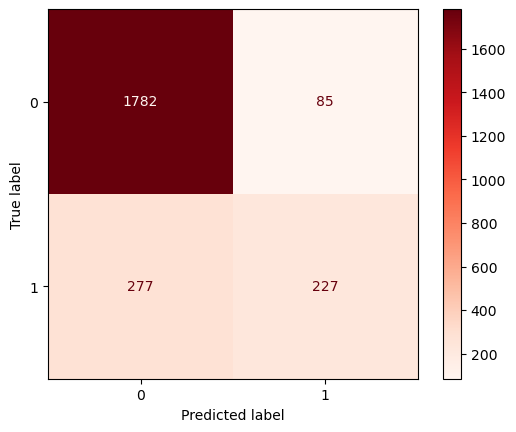

In [47]:
# check performance model against train-set
y_pred_train = pipe_svc.predict(X_train_feature)

print('F1 Score - Train Set  : ', f1_score(y_train, y_pred_train), '\n')
print('Classification Report : \n', classification_report(y_train, y_pred_train), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_train_feature, y_train, cmap='Reds'))

F1 Score - Test Set   :  0.5622119815668203 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       462
           1       0.71      0.47      0.56       131

    accuracy                           0.84       593
   macro avg       0.79      0.71      0.73       593
weighted avg       0.83      0.84      0.83       593
 

Confusion Matrix      : 


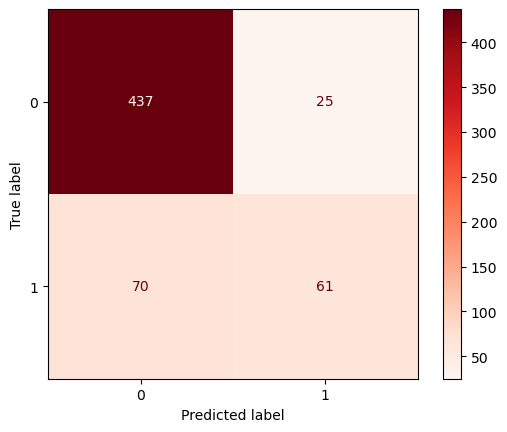

In [48]:
# check performance model against test-set
y_pred_test = pipe_svc.predict(X_test_feature)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test_feature, y_test, cmap='Reds'))

In [49]:
# define confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# confusion matrix to extract False Positive
fp = cm[0][1]

# confusion matrix to extract False Negative
fn = cm[1][0]

In [50]:
# save classification report into a dictionary
all_reports = {}
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
  score_reports = {
      'train - f1_score' : f1_score(y_train, y_pred_train),
      'test - f1_score' : f1_score(y_test, y_pred_test),
      'test - false positive' : fp,
      'test - false negative' : fn
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'Baseline (Default Hyperparameter)')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter)
train - f1_score,0.556373
test - f1_score,0.562212
test - false positive,25.000000
test - false negative,70.000000


### Hyperparameter Tuning: Grid Search

Untuk menemukan kombinasi parameter optimal untuk model machine learning, kita akan menggunakan teknik grid search dengan melakukan semua percobaan pada setiap kombinasi dengan parameter yang telah ditentukan untuk menentukan kombinasi terbaik dari model.

In [51]:
# define hyperparameters grid
kernel = ['linear','rbf']
C = [1,1.25,1.5,1.75,2,2.25,2.5,2.75,3]
gamma = [0.1,0.001,0.025,0.05,'scale','auto']
# degree = [1,5,10,15,20]

grid_search_params = {'svc__kernel': kernel,
                        'svc__C': C,
                        'svc__gamma': gamma}
                        # 'svc__degree': degree}
grid_search_params

{'svc__kernel': ['linear', 'rbf'],
 'svc__C': [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3],
 'svc__gamma': [0.1, 0.001, 0.025, 0.05, 'scale', 'auto']}

In [52]:
# train with grid search
svm_gridcv = GridSearchCV(estimator=pipe_svc,
                                 param_grid=grid_search_params,
                                 cv=3,
                                 n_jobs=-1,
                                 scoring='f1')
svm_gridcv.fit(X_train_feature, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         MinMaxScaler(),
                                                                         ['limit_balance'])])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3],
                         'svc__gamma': [0.1, 0.001, 0.025, 0.05, 'scale',
                                        'auto'],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='f1')

In [53]:
# get best hyperparameters
svm_gridcv.best_params_

{'svc__C': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}

Dari hasil percobaan yang dilakukan, kombinasi terbaiknya adalah:
`{'svc__C': 2, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}`

In [54]:
# get best estimator
svm_gridcv_best = svm_gridcv.best_estimator_

F1 Score - Test Set   :  0.5622119815668203 

Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       462
           1       0.71      0.47      0.56       131

    accuracy                           0.84       593
   macro avg       0.79      0.71      0.73       593
weighted avg       0.83      0.84      0.83       593
 

Confusion Matrix      : 


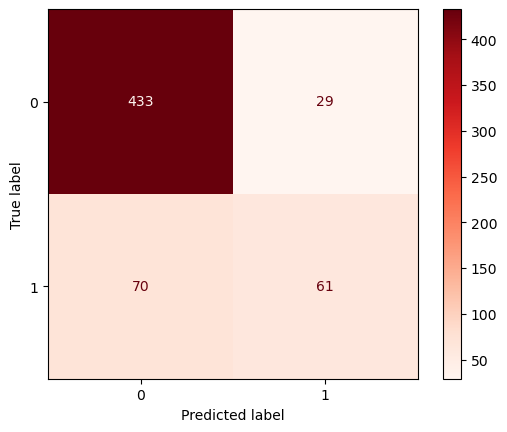

In [55]:
# check performance model against test-set
y_pred_test_tunning = svm_gridcv.best_estimator_.predict(X_test_feature)

print('F1 Score - Test Set   : ', f1_score(y_test, y_pred_test), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_estimator(svm_gridcv.best_estimator_, X_test_feature, y_test, cmap='Reds'))

In [56]:
# define confusion matrix
cm_tuning = confusion_matrix(y_test, y_pred_test_tunning)

# confusion matrix to extract False Positive
fp_tuning = cm_tuning[0][1]

# confusion matrix to extract False Negative
fn_tuning = cm_tuning[1][0]

In [57]:
# save classification report into a dictionary
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test_tunning, 'Grid Search')
pd.DataFrame(all_reports)

,Baseline (Default Hyperparameter),Grid Search
train - f1_score,0.556373,0.556373
test - f1_score,0.562212,0.552036
test - false positive,25.000000,25.000000
test - false negative,70.000000,70.000000


Berdasarkan hasil percobaan, hasil menunjukkan bahwa perubahan hanya terjadi pada test f1 score dengan adanya penurunan menjadi 0.552036. Meskipun begitu, selisih antara train dan test set berkurang menjadi 0.004 yang menunjukkan `adanya improvement model menjadi goodfit` dari yang sebelumnya condong pada overfitting.

## Model Saving

In [58]:
# save files
with open('svm_gridcv_best.pkl', 'wb') as file_1:
  pickle.dump(svm_gridcv_best, file_1)

## Model Inference

Model inference adalah proses penerapan model mission learning yang telah dibuat untuk memprediksi data. File notebook untuk model inference dibuat terpisah pada notebook `inference_divani.ipynb` karena pada notebook ini terdapat data bersifat rahasia yang berisikan data-data confidential.

## Conclusion

- Perbedaan jumlah customer yang gagal bayar dan tidak gagal bayar sangat signifikan, dimana hal ini menandakan bahwa diperkirakan 78.58% customer akan berhasil membayar tagihan kartu kredit pada bulan depan dengan persentase No Default lebih besar +21.42%.
- Perbedaan persentase jumlah status pernikahan customer yang tidak terlalu jauh antara single dan married, dengan persentase perbedaan hanya +8.87%. Sedangkan, terdapat 1.32% customer yang termasuk kedalam kategori others, seperti divorced atau tidak mengisi statusnya.
- Education level dari customer credit card yang paling banyak berasal dari lulusan university yaitu 1400 customer, dengan perbedaan yang cukup signifikan jika dibandingkan dengan lulusan lainnya.
- Umur dari customer credit card yang bervariasi, dengan dominasi umur yang paling banyak ada pada range umur 24-36 dimana jumlah customer tiap usia lebih dari 100 orang.
- Jumlah customer yang memiliki jumlah limit kartu kredit yang kecil sangat banyak, dengan dominasi 348 orang memiliki limit balance 50000 dan sekitar 200 orang memiliki limit balance 20000.
- Semakin tinggi limit kartu kreditnya maka probabilitas customer untuk membayar tagihannya bulan berikutnya makin besar.
- Customer kartu kredit didominasi oleh gender Female, dimana customer Female memiliki kemampuan untuk membayar tagihan kartu kredit untuk bulan depan lebih besar daripada Male.

Berdasarkan insight dari hasil exploratory data analysis, untuk dapat memprediksi apakah customer dapat membayar tagihan kartu kredit pada bulan depan atau tidak kita harus melihat faktor-faktor seperti jumlah customer yang tidak gagal bayar, limit balance kartu kredit, tingkat pendidikan, umur, dan jenis kelamin. Untuk itu, rekomendasi bisnis agar dapat mengurangi kerugian bank dengan layanan kartu kredit adalah dengan membuat model machine learning, dimana tujuan yang ingin dicapai adalah mengurangi false positive dan false negative, dimana false positif di definisikan sebagai penolakan transaksi yang sah atau pembekuan kartu secara tidak perlu yang dapat membuat customer kehilangan kepercayaan kepada bank, sedangkan false negatif adalah tidak terdeteksinya transaksi curang yang dilakukan secara tidak sah yang dapat merusak reputasi bank.

Untuk kasus kartu kredit default ini, pembuatan model machine learning akan menggunakan model clasification LogisticRegression, KNeighborsClassifier, SVC. Alasan menggunakan ketiga model classification tersebut adalah untuk mengurangi resiko overfitting dengan membandingkan performa beberapa model yang berbeda dan menentukan model mana yang paling cocok, hal ini dikarenakan setiap model memiliki karakteristik yang berbeda. Dengan menggabungkan ketiga model tersebut, kita dapat memperluas cara model memahami data dan menghindari ketergantungan terhadap satu model tertentu. Selanjutnya adalah melakukan cross-validation untuk memastikan konsistensi dan akurasi dengan cara membagi data menjadi subset yang lebih kecil untuk menghindari overfitting. Tujuan utama dari cross-validation adalah memberikan perkiraan yang lebih akurat tentang bagaimana model akan perform pada data baru.

Dari hasil perbandingan dengan menggunakan cross validation, best modelnya adalah Support Vector Machine (SVM) dengan nilai mean 0.5125931583264429. Karena best model adalah SVM, maka selanjutnya kita akan melakukan hyperparameter tuning pada model SVM, dimana hyperparameter tuning adalah proses pencarian kombinasi parameter optimal untuk model machine learning. Dalam hal ini, kita akan menggunakan teknik grid search dengan melakukan semua percobaan pada setiap kombinasi dengan parameter yang telah ditentukan untuk menentukan kombinasi terbaik dari model.

Setelah melakukan hyperparameter tuning pada model mission learning, hasil evaluasi model machine learning menujukkan `adanya improvement model menjadi goodfit` dari yang sebelumnya condong ke overfitting, dimana hal ini didasari oleh selisih nilai pada train-set dan test-set menjadi 0.004.

Berikut adalah hasil evaluasi dari hyperparameter tuning grid search menggunakan SVM dan F1 Score:
1. Train - F1 Score:
- Baseline      : 0.556373
- Grid Search   : 0.556373

2. Test - F1 Score:
- Baseline      : 0.562212
- Grid Search   : 0.552036

3. Train - false positive:
- Baseline      : 25.000000
- Grid Search   : 25.000000

4. Test - false negative:
- Baseline      : 70.000000
- Grid Search   : 70.000000

Kelemahan dari model yang telah dibuat adalah sebagai berikut:
- Tidak ada improvement pada kesalahan hasil prediksi customer default dan no default, dimana hasilnya tetap 25 dan 70 setelah tuning.
- Terjadi penurunan pada hasil prediksi test-set dan tidak ada improvement pada hasil train-set.

Meskipun jika kita membandingkan sebelum dan sesudah tuning terlihat bahwa tidak ada improvement pada model machine learning, berikut kelebihan dari model yang telah dibuat:
- Meskipun hasil test-set mengalami penurunan, tetapi range/selisih train-set dan test-set menjadi lebih kecil sehingga model dapat dikatakan menjadi goodfit.
- Meskipun kesalahan hasil prediksi customer default dan non default tetap sama, tetapi total kesalahan hasil prediksi hanya 100 dari 600 data test-set. Artinya, akurasi prediksi model machine learning adalah 84%, dimana akurasi diatas 80% sudah dikategorikan baik dan konsisten dalam melakukan prediksi.
- Menggunakan kernel 'linear' dan 'rbf' pada modeling dan training nya untuk dapat mengatasi dataset yang linear dan non linear.
- Menggunakan GridSearch untuk hyperparameter tuning agar hasil modeling dan training lebih optimal karena melakukan semua percobaan pada setiap kombinasi dengan parameter yang telah ditentukan untuk menentukan kombinasi terbaik dari model.

Oleh karena itu, hal yang bisa diimprove agar hasil evaluasi machine learning lebih optimal adalah sebagai berikut:
- Kasus prediksi kartu kredit default ini kemungkinan memiliki klasifikasi yang spesifik, sehingga perlu untuk menambahkan kernel 'poly' dan parameter degree pada hyperparameter tuning grid search agar hasil train-set dan test-set lebih optimal. 
- Melakukan handling outlier dengan cara trimming data untuk hasil presentase outlier dibawah 5%. Meskipun hal ini akan mengurangi jumlah data yang akan di train, diharapkan akan ada improvement pada hasil train-set dan test-set sehingga dapat meminimalisir kesalahan hasil prediksi.

Berikut adalah analisis statistik untuk evaluasi model machine learning dalam konteks prediksi default kartu kredit dengan yang membagi data evaluasi berdasarkan hasil prediksi menjadi empat kelompok: False Negative (FN), True Negative (TN), False Positive (FP), dan True Positive (TP). Tujuan dari perhitungan ini adalah untuk mengidentifikasi bagaimana variable pembayaran (pay_0, pay_2, pay_3, pay_4, pay_5, pay_6) mempengaruhi hasil prediksi dan memberikan wawasan untuk memahami kinerja model serta mengambil keputusan terkait perbaikan atau pengembangan model.

In [62]:
# create new column
evaluation = X_test.copy() #create duplicate 
evaluation['label'] = y_test
evaluation['prediction'] = y_pred_test_tunning

# devide evaluation data based on prediction and label
fn_eval = evaluation[(evaluation['label'] == 1) & (evaluation['prediction'] == 0)]
tn_eval = evaluation[(evaluation['label'] == 0) & (evaluation['prediction'] == 0)]
fp_eval = evaluation[(evaluation['label'] == 0) & (evaluation['prediction'] == 1)]
tp_eval = evaluation[(evaluation['label'] == 1) & (evaluation['prediction'] == 1)]

# statistics for each subset
pay = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
fn_stats = fn_eval[pay].describe().loc[['mean','50%','min','max']]
tn_stats = tn_eval[pay].describe().loc[['mean','50%','min','max']]
fp_stats = fp_eval[pay].describe().loc[['mean','50%','min','max']]
tp_stats = tp_eval[pay].describe().loc[['mean','50%','min','max']]

print(f'\nStatistics for False Negative: \n{fn_stats}')
print(f'\nStatistics for True Negative: \n{tn_stats}')
print(f'\nStatistics for False Positive: \n{fp_stats}')
print(f'\nStatistics for True Positive: \n{tp_stats}')


Statistics for False Negative: 
         pay_0     pay_2  pay_3     pay_4     pay_5  pay_6
mean -0.028571 -0.385714   -0.4 -0.528571 -0.485714   -0.4
50%   0.000000  0.000000    0.0  0.000000  0.000000    0.0
min  -2.000000 -2.000000   -2.0 -2.000000 -2.000000   -2.0
max   2.000000  2.000000    2.0  2.000000  2.000000    2.0

Statistics for True Negative: 
         pay_0     pay_2     pay_3     pay_4     pay_5     pay_6
mean -0.344111 -0.431871 -0.443418 -0.413395 -0.473441 -0.473441
50%   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
min  -2.000000 -2.000000 -2.000000 -2.000000 -2.000000 -2.000000
max   5.000000  4.000000  3.000000  2.000000  2.000000  3.000000

Statistics for False Positive: 
        pay_0     pay_2     pay_3     pay_4     pay_5     pay_6
mean  1.37931  1.482759  1.413793  0.448276  0.655172  0.206897
50%   1.00000  2.000000  2.000000  0.000000  0.000000  0.000000
min  -1.00000 -1.000000  0.000000 -1.000000 -1.000000 -2.000000
max   4.00000  4.000000  3

Analisis statistik di atas memberikan gambaran tentang bagaimana variabel pembayaran mempengaruhi hasil prediksi model untuk setiap kategori. Informasi ini penting untuk memahami perbedaan dalam karakteristik pembayaran antar kelompok prediksi dan pengambilan keputusan terkait pengembangan model dan analisis data lebih lanjut.

## Conceptual Problems

1. Dalam logistic regression, coefficient menggambarkan seberapa besar dampak dari variable prediktor terhadap kemungkinan keberhasilan atau kegagalan suatu peristiwa. Model ini digunakan untuk memprediksi probabilitas dari peristiwa biner, seperti sukses/gagal, ya/tidak. Output dari logistic regression berupa log-odds, dimana hal ini merupakan perbandingan antara probabilitas keberhasilan (p) dengan probabilitas kegagalan (1-p).
Ketika kita melihat coefficient dalam logistic regression, kita mencari tahu seberapa besar perubahan dalam log-odds dari variabel target yang terjadi ketika variabel prediktor berubah satu unit, dengan asumsi bahwa semua variabel prediktor lainnya tidak berubah. Ketika coefficient positif, hal ini menunjukkan bahwa peningkatan dalam variabel prediktor tersebut akan meningkatkan log-odds dari variabel target dan meningkatkan kemungkinan terjadinya peristiwa yang diprediksi sebagai keberhasilan. Sebaliknya, jika coefficient negatif, hal ini menandakan bahwa peningkatan dalam variabel prediktor akan menurunkan log-odds dari variabel target dan mengurangi kemungkinan peristiwa tersebut terjadi.

2. Support Vector Machine (SVM) adalah algoritma supervised learning untuk regression dan classification. Dalam SVM, parameter yang umum digunakan untuk hyperparameter tuning adalah kernel, C, dan gamma. Parameter kernel pada SVM berfungsi untuk menentukan jenis fungsi yang digunakan untuk mentransformasikan data ke dalam ruang fitur yang lebih tinggi dalam bentuk 3Dimensi sehingga data dapat dipisahkan dengan cara linear di ruang tersebut menjadi bentuk 2Dimensi. Terdapat 5 parameter kernel pada SVM, yaitu kernel rbf sebagai parameter default, linear, poly, sigmoid, dan precomputed.
Kernel SVM yang umum digunakan adalah kernel rbf. Fungsi kernel RBF adalah mentransformasikan data dengan mengukur jarak radial (jarak dari pusat) antara titik data, dimana rbf akan cocok untuk kasus-kasus di mana batas keputusan tidak linier karena dapat menyesuaikan bentuk dan kompleksitas yang lebih besar dari batas keputusan. Hal ini memungkinkan SVM menemukan hyperplane (batas keputusan) yang optimal untuk memisahkan kelas data dengan baik, khususnya pada data yang kompleks dan non-linear.

3. K-Nearest Neighbors (KNN) adalah salah satu algoritma supervised learning untuk regression dan classification. KNN bersifat non parametric, dimana hanya mempelajari model dengan melihat dan menghafal semua data yang ditraining saja (lazy learning) sehingga tidak ada asumsi karena tidak menghitung berdasarkan data. Oleh karena itu, dapat disimpulkan bahwa training data menggunakan KNN akan lebih cepat, tetapi saat melakukan prediksi akan lebih lama karena akan membaca datanya satu persatu. Lalu, cara KNN membuat klasifikasi adalah dengan melihat nilai k, dimana k adalah jumlah 'tetangga' yang akan dilihat machine learning karena mengganggap data yang berdekatan memiliki feature yang sama berdasarkan jaraknya. 
Pemilihan nilai k yang optimal KNN penting dilakukan untuk mencapai keseimbangan yang tepat antara akurasi model dan kemampuannya memprediksi data baru. Nilai k yang terlalu kecil dapat menyebabkan model rentan terhadap outlier, sedangkan nilai k yang terlalu besar dapat membuat model terlalu sederhana dan cenderung underfit. Untuk menentukan k yang optimal, penting untuk menggunakan teknik seperti cross-validation dengan membagi data menjadi train-set dan validation-set untuk mengevaluasi kinerja model pada berbagai nilai k dan memilih nilai k yang memberikan hasil terbaik berdasarkan metric evaluasi yang dipilih (accuracy, precision, recall, F1 score).

4. Pada logistic regression terdapat 4 metrics classification, yaitu `Accuracy, Preccision, Recall, dan F1 Score`.
- Accuracy: 
    - Mengukur seberapa tepat model memprediksi secara keseluruhan dengan benar, baik positif maupun negatif.
    - Metric ini cocok digunakan ketika distribusi data yang seimbang/balance, jika imbalance maka hasilnya akan misleading. Selain proporsi prefectly balance 50:50, 60:40 atau 65:35 masih dikategorikan sebagai distribusi data seimbang.
    - Contoh kasusnya adalah jika dari 100 data berhasil memprediksi 80 dengan benar, maka akurasi modelnya adalah 80%.

- Precision: 
    - Mengetahui seberapa akurat model dalam memprediksi data yang seharusnya diprediksi negatif.
    - Metric ini cocok digunakan ketika kita ingin meminimalisir prediksi positif yang sebenarnya negatif (False Positive), seperti contoh kasus mendeteksi spam pada email dan akses fingerprint kantor.
    - Rumus = TP/TP+FP, artinya hasil precision akan tinggi jika nilai FP makin rendah.

- Recall:
    - Mengetahui seberapa baik model dalam menangkap data yang seharusnya diprediksi positif.
    - Metric ini cocok digunakan ketika kita ingin meminimalisir prediksi negatif yang sebenarnya positif (False Negative), seperti contoh kasus mendeteksi penyakit covid, diabetes, dan penyakit lainnya.
    - Rumus = TP/TP+FN, artinya hasil recall akan tinggi jika nilai FN makin rendah.

- F1 Score:
    - Memberikan gambaran yang seimbang tentang kinerja model dengan mempertimbangkan precision dan recall.
    - Metric ini cocok digunakan ketika kita tidak bisa menentukan karena False Positice dan False Negative sama pentingnya sehingga akan meminimalisir keduanya.
    - Rumus = harmonic mean/rata-rata dari hasil precision dan recall, jika hasil precision naik maka hasil recall akan turun, vice versa.